/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_64180/2516553708.py:138: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, x_max*1.0)
/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T

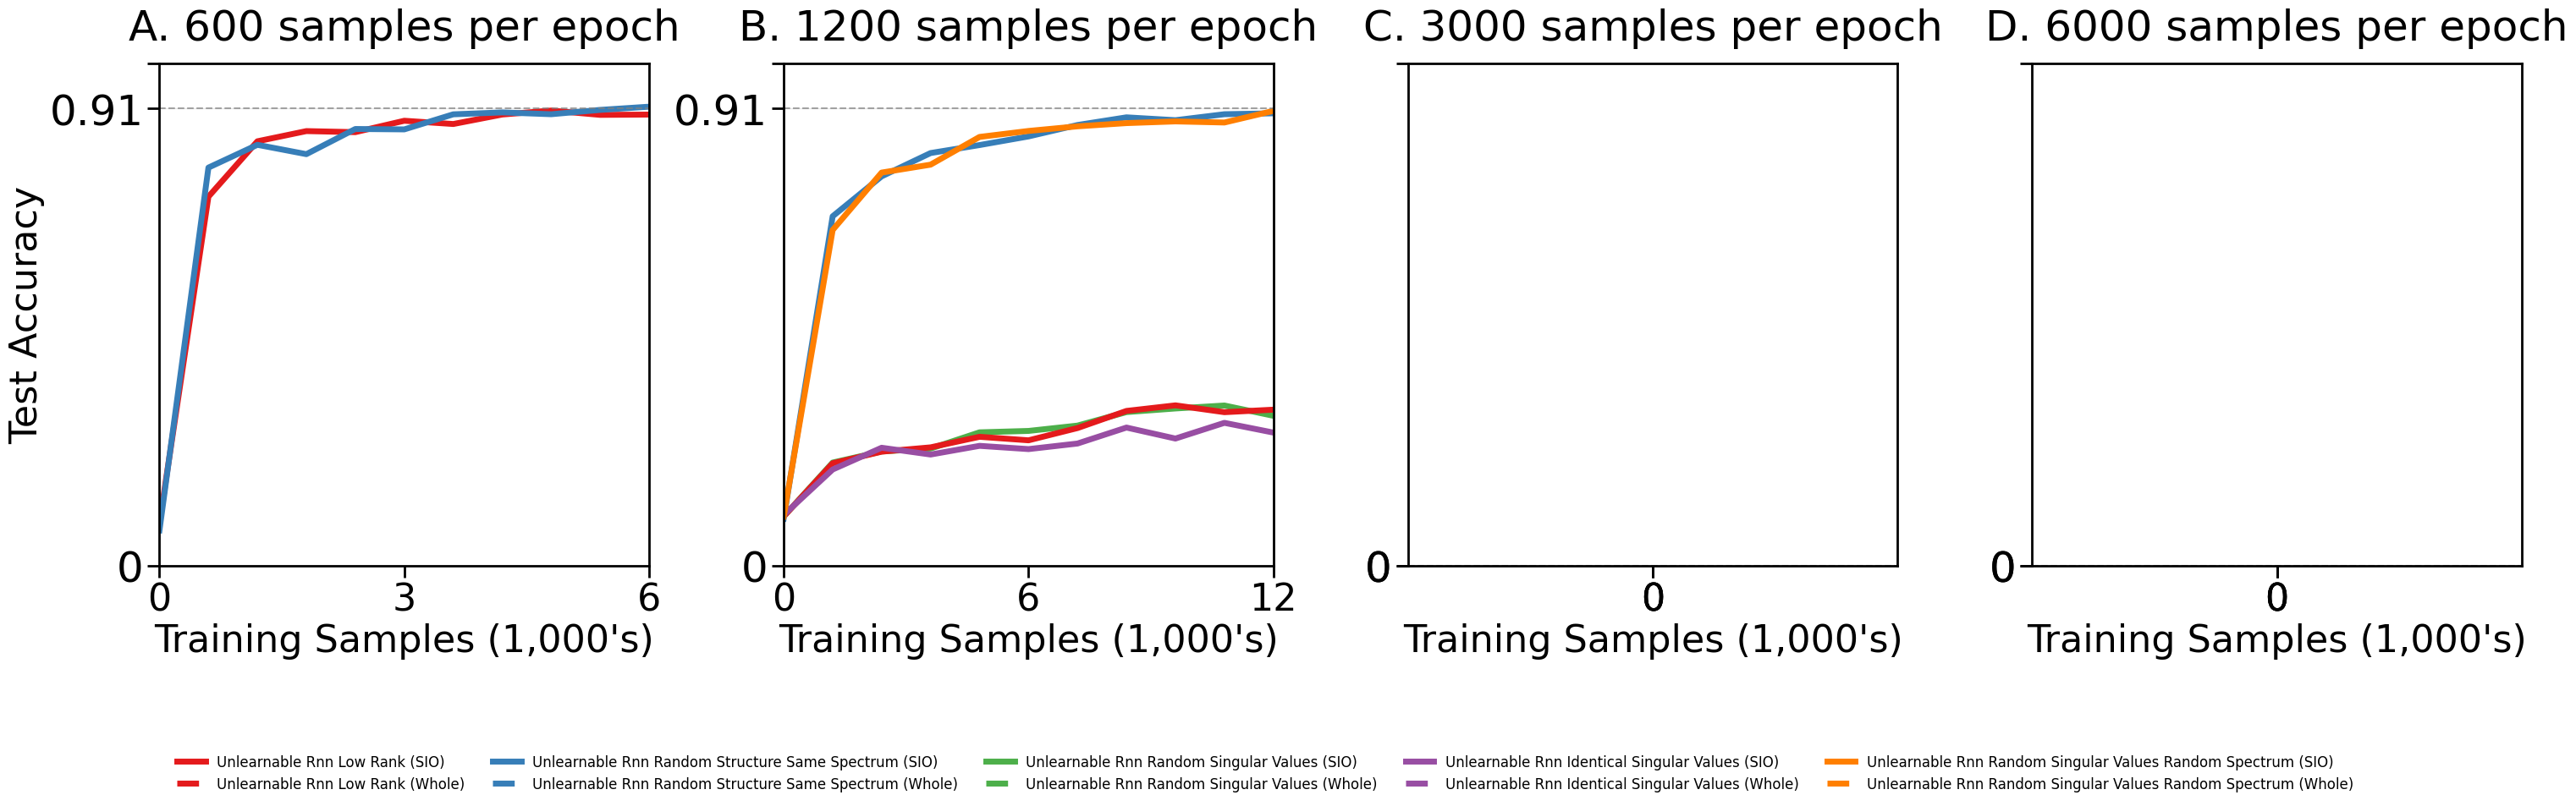

In [10]:
import os
import sys
import re
import pickle
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_weight_matrix

RESULTS_DIR = "../results/"
SELECTED_SAMPLES = ["1%", "2%", "5%", "10%"]  # List of samples to plot

# Updated color map for experiments
COLOR_MAP = {
    "Unlearnable_RNN_Low_Rank": "#E41A1C",
    "Unlearnable_RNN_Random_Structure_Same_Spectrum": "#377EB8",
    "Unlearnable_RNN_Random_Singular_Values": "#4DAF4A",
    "Unlearnable_RNN_Identical_Singular_Values": "#984EA3",
    "Unlearnable_RNN_Random_Singular_Values_Random_Spectrum": "#FF7F00"
}

def load_results(selected_sample):
    target_samples = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
  
    data = {}
    pattern = re.compile(r"^(?P<exp>\w+?)(_fewshot_\d+)?(_trial\d+)?(\.whole)?(\.signed)?\.pkl$")
  
    for fname in os.listdir(RESULTS_DIR):
        match = pattern.match(fname)
        if not match: continue
      
        exp_name = match.group("exp")
        if "_fewshot" in fname:
            samples = int(fname.split("_fewshot_")[1].split("_")[0])
            if samples != target_samples: continue
        else:
            continue
            
        # Check if it's a whole matrix version
        is_whole = ".whole" in fname
      
        try:
            with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
                results = pickle.load(f)
                if 'epoch_test_acc' in results:
                    # Store both the accuracy list and whether it's whole matrix
                    data[exp_name] = {
                        'acc_list': results['epoch_test_acc'],
                        'is_whole': is_whole
                    }
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue
  
    return data

def plot_results(data, ax, selected_sample, global_y_max, panel_position):
    x_max = 0
    max_acc = 0
    
    for exp_name, exp_data in data.items():
        if exp_name not in COLOR_MAP:
            continue
            
        acc_list = exp_data['acc_list']
        # Handle both single trial and multiple trials cases
        if isinstance(acc_list, list):
            if len(acc_list) == 0:
                continue
            if isinstance(acc_list[0], list):
                acc_matrix = np.array(acc_list)
                epochs = acc_matrix.shape[1]
            else:
                acc_matrix = np.array([acc_list])
                epochs = len(acc_list)
        else:
            acc_matrix = np.array([acc_list])
            epochs = len(acc_list)
      
        mean = np.mean(acc_matrix, axis=0)
        std = np.std(acc_matrix, axis=0, ddof=1)
        max_acc = max(max_acc, np.max(mean))
      
        target_samples = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
        x = np.arange(epochs) * target_samples * 10 / 1000  # Convert to thousands
        x_max = max(x_max, x[-1])
      
        # Use solid line for SIO and dashed line for whole matrix
        linestyle = '--' if exp_data['is_whole'] else '-'
        linewidth = 5.0
      
        ax.plot(
            x, mean,
            color=COLOR_MAP[exp_name],
            linewidth=linewidth,
            linestyle=linestyle
        )
      
        ax.fill_between(
            x, mean - std, mean + std,
            color=COLOR_MAP[exp_name],
            alpha=0.15
        )
    
    # Add max accuracy line
    rounded_max_acc = round(max_acc, 2)
    ax.axhline(y=rounded_max_acc, color='gray', linestyle='--', alpha=0.7)
    
    # Set y-axis ticks for all panels including the max value
    y_ticks = [0, rounded_max_acc, 1.0]
    # Adjust label positioning to avoid overlap
    y_labels = ['0', f'{rounded_max_acc}', '']
    ax.set_ylim(0, 1)  
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=36)
    
    # Set x-axis ticks
    x_ticks = [0, x_max/2, x_max]
    x_labels = [f"{int(x)}" for x in x_ticks]  # Remove decimal places
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=32)
    
    # Set axis labels only for appropriate panels
    ax.set_xlabel("Training Samples (1,000's)", fontsize=32)
        
    if panel_position == 'A':  # Only first panel has y-axis label
        ax.set_ylabel("Test Accuracy", fontsize=32)
    else:
        ax.set_ylabel("")
    
    # Set title for all panels with panel letter integrated
    target_samples = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
    ax.set_title(f"{panel_position}. {target_samples*10} samples per epoch", fontsize=36, pad=20)
    
    # Set limits and grid
    ax.set_xlim(0, x_max*1.0)
    ax.grid(True, axis='y', alpha=0.3)  # Only horizontal grid lines
    
    # Make tick marks thicker
    ax.tick_params(width=2, length=10)
    
    return max_acc

def create_custom_legend():
    legend_elements = []
    for exp_name, color in COLOR_MAP.items():
        # Add solid line for SIO version
        legend_elements.append(
            plt.Line2D([0], [0], color=color, lw=5.0, linestyle='-',
                      label=f"{exp_name.replace('_', ' ').title()} (SIO)")
        )
        # Add dashed line for whole matrix version
        legend_elements.append(
            plt.Line2D([0], [0], color=color, lw=5.0, linestyle='--',
                      label=f"{exp_name.replace('_', ' ').title()} (Whole)")
        )
    return legend_elements

if __name__ == "__main__":
    # Create a 1x4 subplot figure
    plt.rcParams['axes.linewidth'] = 2.0  # Make all axis lines thicker
    fig, axes = plt.subplots(1, 4, figsize=(30, 8))
    
    # First, collect all data and determine global max y-value
    all_data = {}
    global_max_acc = 0
    
    for sample in SELECTED_SAMPLES:
        experiment_data = load_results(sample)
        all_data[sample] = experiment_data
        
        # Find max accuracy across all panels
        for exp_name, exp_data in experiment_data.items():
            if exp_name not in COLOR_MAP:
                continue
            acc_matrix = np.array(exp_data['acc_list'])
            mean = np.mean(acc_matrix, axis=0)
            global_max_acc = max(global_max_acc, np.max(mean))
    
    # Use a consistent y-axis scaling with a bit of padding
    global_y_max = max(1.0, global_max_acc * 1.1)
    
    # Plot each panel with consistent y-axis scaling
    panel_labels = ['A', 'B', 'C', 'D']
    for idx, sample in enumerate(SELECTED_SAMPLES):
        plot_results(all_data[sample], axes[idx], sample, global_y_max, panel_labels[idx])
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.25)
    plt.tight_layout()
    
    # Add legend to the bottom of the figure
    legend = fig.legend(
        handles=create_custom_legend(),
        loc="center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=5,  # Changed to 2 columns for better layout
        frameon=False,
        fontsize=16,
    )
    
    # Save figure
    os.makedirs('figures', exist_ok=True)
    plt.savefig("./figures/svd_modes_performance.pdf", bbox_inches="tight")
    plt.savefig("./figures/svd_modes_performance.png", bbox_inches="tight", dpi=300)
    plt.show() 